## 7. Merge HUC8 with HUC8 Stream Outlet Stats + Simplify

Use this notebook to join stream segments statistics to HUC8 polygons. Only the stats from streams flagged as HUC8 outlets will be joined. The HUC8 polygon layer is then simplified and saved.

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

### Load files

In [15]:
stats = gpd.read_file("/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/xwalk/seg_h8_outlet_stats_simplified.shp")

In [16]:
huc8 = gpd.read_file("/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/WBDHU8.shp")

### Subset and assess

In [17]:
# we only want CONUS HUC8s, so we need to drop any HUC8s that are in AK, HI, the territories, or other countries
states_to_drop = ["AK", "HI", "DC", "PR", "VI", "GU", "MP", "MX", "CN", "UM", "AS"]

# first drop nans
huc8 = huc8.dropna(subset=["states"])
# then split the states column into a list of states
huc8["states_list"] = huc8["states"].apply(lambda x: x.split(","))

# print a set of unique states found
# unique_states = set(state for states in huc8["states_list"] for state in states)
# print(unique_states)

# then check if any of the states in the list are not in the drop list
# if any state in the list is not in the drop list, keep the HUC8
# this will keep HUC8s that are in the CONUS, even if they have some area in AK, HI, or the territories

huc8["keep"] = huc8["states_list"].apply(lambda x: any(state not in states_to_drop for state in x))
# finally, filter the HUC8s to only those that we want to keep
huc8_conus = huc8[huc8["keep"]].drop(columns=["states", "states_list", "keep"])
huc8_conus = huc8_conus[["huc8", "name", "geometry"]]

In [18]:
h8_stats = stats[stats["h8_outlet"]==1].drop(columns=["h8_outlet", "geometry"])
# if there are any duplicate huc8 values, choose the one with higher ma99_hist
# this will (probably) choose the bigger stream segment, which is more likely to be the outlet
h8_stats = h8_stats.sort_values(by="ma99_hist", ascending=False).drop_duplicates(subset="huc8")

In [19]:
print(len(huc8_conus))
print(len(h8_stats))

2120
2052


Roughly 70 HUC8s do not have an outlet identified. These are maybe along the coast where multiple streams can run right into the ocean... we will test this later after joining.

### Join by HUC8 ID + Plot

In [20]:
huc8_conus_stats = huc8_conus.merge(h8_stats, on="huc8", how="left").drop(columns=["GNIS_NAME", "GAUGE_ID"])
huc8_conus_stats

,huc8,name,geometry,seg_id_nat,ma12_min_d,ma12_avg_d,ma12_max_d,ma13_min_d,ma13_avg_d,ma13_max_d,...,dl16_min_d,dl16_max_d,fh1_min_d,fh1_max_d,fl1_min_d,fl1_max_d,ma99_min_d,ma99_avg_d,ma99_max_d,ma99_hist
0,04080204,Flint,"POLYGON ((-83.24547 43.35439, -83.24507 43.354...",11111.0,-54.16,-19.57,8.19,-46.13,-5.70,18.67,...,-2.89,4.62,-1.30,0.00,-1.30,1.53,-38.97,-15.02,0.21,815.91
1,04090003,Clinton,"POLYGON ((-83.01797 42.94371, -83.01772 42.943...",11276.0,-27.71,11.34,32.16,-20.85,17.47,41.39,...,-1.11,5.37,-2.53,-0.53,-1.83,0.90,-14.20,5.13,16.82,741.25
2,04030106,Brule,"POLYGON ((-88.54782 46.53939, -88.54764 46.539...",11354.0,10.08,132.01,204.89,17.44,128.24,225.68,...,-3.72,2.38,0.54,2.24,0.20,1.50,-39.44,-0.31,25.78,740.36
3,18100204,Salton Sea,"POLYGON ((-115.92055 33.81369, -115.92045 33.8...",56312.0,-94.41,-81.79,-63.40,-94.98,-66.26,-37.57,...,-9.62,-0.31,-0.77,4.76,0.70,5.73,-86.16,-62.09,-34.64,35.48
4,04020102,Ontonagon,"POLYGON ((-89.32617 46.87654, -89.32562 46.876...",10488.0,37.26,116.34,186.48,38.99,110.65,185.37,...,-15.74,-10.95,0.17,3.34,3.00,5.84,-31.73,-4.84,16.73,1298.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115,02030102,Bronx,"POLYGON ((-73.74828 41.15462, -73.74791 41.154...",2595.0,-20.11,4.11,25.01,1.64,16.58,53.08,...,-0.98,0.16,0.07,4.74,-1.46,3.10,-21.31,-15.60,-5.21,182.29
2116,02040105,Middle Delaware-Musconetcong,"POLYGON ((-74.7232 41.18883, -74.72333 41.1887...",1498.0,5.37,24.76,35.95,7.63,27.06,51.49,...,-0.58,6.85,-1.47,0.77,-2.06,0.17,-22.39,-12.59,-5.88,11865.96
2117,02030105,Raritan,"POLYGON ((-74.62983 40.91488, -74.63059 40.914...",2685.0,-12.86,9.55,20.32,11.06,25.87,51.31,...,-2.43,1.83,1.77,4.10,-0.76,1.90,-22.05,-17.53,-9.36,2581.19
2118,01100006,Saugatuck,"POLYGON ((-73.44309 41.36726, -73.44306 41.367...",1243.0,-4.53,18.65,32.46,10.67,30.59,58.31,...,-1.75,0.78,0.80,4.44,-1.37,5.43,-10.38,-0.51,6.53,162.20


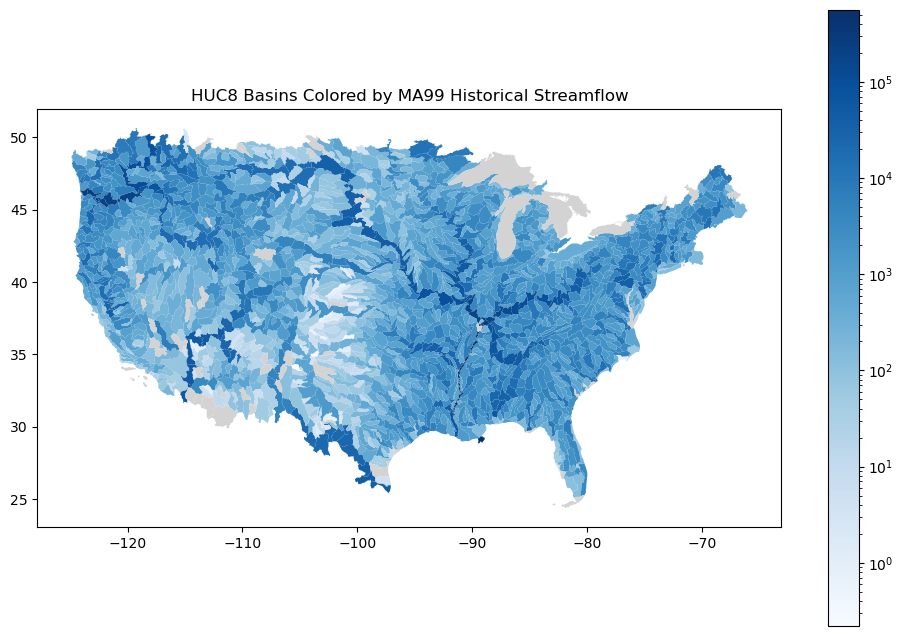

In [21]:
# plot using the ma99_hist column to color the huc8 polygons
# if ma99_hist is null, color it light gray
fig, ax = plt.subplots(figsize=(12, 8))
huc8_conus_stats.plot(ax=ax, column="ma99_hist", cmap='Blues', norm=colors.LogNorm(), missing_kwds={"color": "lightgray"}, legend=True)
plt.title("HUC8 Basins Colored by MA99 Historical Streamflow")
plt.show()

### Simplify polygons + Plot

In [22]:
# reproject so we can use meters for tolerance - let's match the CRS for the segments dataset
huc8_conus_stats_reproj = huc8_conus_stats.to_crs(stats.crs)

In [23]:
# Use simplify_coverage for polygon layer simplification
# NOTE that this requires shapely >= 2.1!
# use shp/environment.yml to build an env with the right version of shapely

huc8_conus_stats_reproj_simplified = huc8_conus_stats_reproj.copy()
huc8_conus_stats_reproj_simplified["geometry"] = gpd.GeoSeries.simplify_coverage(
    huc8_conus_stats_reproj_simplified.geometry, tolerance=500, simplify_boundary=True
)

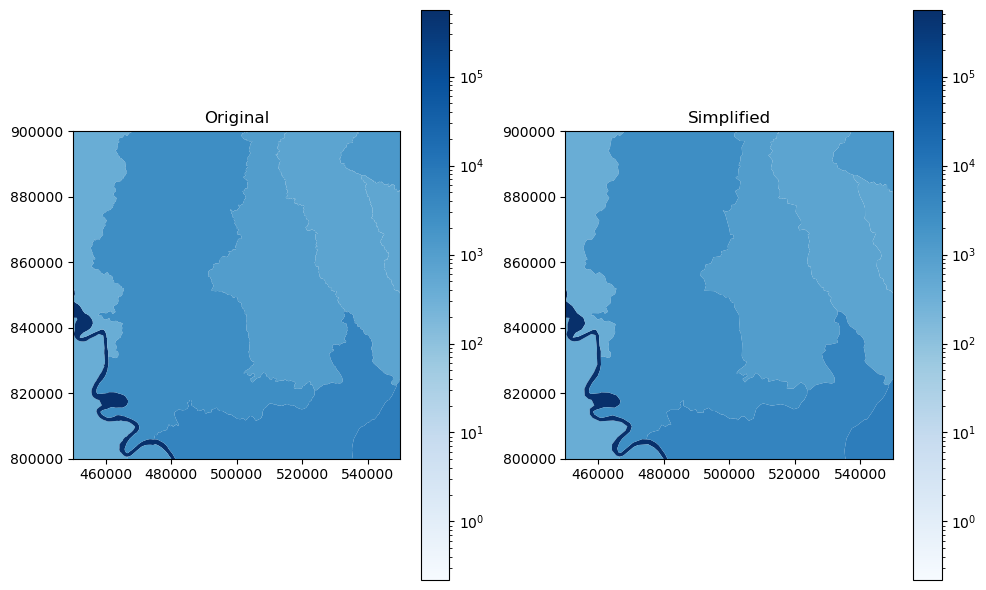

In [24]:
# plot using the ma99_hist column to color the huc8 polygons
# if ma99_hist is null, color it light gray

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
huc8_conus_stats.to_crs(stats.crs).plot(ax=ax[0], column="ma99_hist", cmap='Blues', norm=colors.LogNorm(), missing_kwds={"color": "lightgray"}, legend=True)
huc8_conus_stats_reproj_simplified.plot(ax=ax[1], column="ma99_hist", cmap='Blues', norm=colors.LogNorm(), missing_kwds={"color": "lightgray"}, legend=True)

ax[0].set_title("Original")
ax[1].set_title("Simplified")

for a in ax.flatten():
    a.set_aspect('equal')
    a.set_xlim(450000, 550000)
    a.set_ylim(800000, 900000)

plt.tight_layout()

### Compare vertex count

In [25]:
# Count all vertices in the entire GeoDataFrame (works for polygons and lines)

def count_vertices(geom):
    if geom is None:
        return 0
    if geom.geom_type == "Polygon":
        return sum(len(ring.coords) for ring in geom.interiors) + len(geom.exterior.coords)
    elif geom.geom_type == "MultiPolygon":
        return sum(count_vertices(poly) for poly in geom.geoms)
    elif geom.geom_type == "LineString":
        return len(geom.coords)
    elif geom.geom_type == "MultiLineString":
        return sum(len(line.coords) for line in geom.geoms)
    else:
        return 0

print(f"Total vertices in original shapefile: {huc8_conus_stats.geometry.apply(count_vertices).sum()}")
print(f"Total vertices in simplified shapefile: {huc8_conus_stats_reproj_simplified.geometry.apply(count_vertices).sum()}")

Total vertices in original shapefile: 24200539
Total vertices in simplified shapefile: 699273


### Save

In [26]:
huc8_conus_stats_reproj_simplified.to_file("/import/beegfs/CMIP6/jdpaul3/hydroviz_data/gis/xwalk/huc8_conus_stats_simplified.shp")